In [140]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.metrics import plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, roc_curve

In [141]:
train_data = pd.read_csv('./data_preprocess_v2/train_df_day_5_1.csv')
test_data = pd.read_csv('./data_preprocess_v2/test_df_day_5_1.csv')

In [142]:
dtr = RandomForestRegressor()
RandomForestRegressor(ccp_alpha= 0, criterion='mse', max_depth=6) 

RandomForestRegressor(ccp_alpha=0, max_depth=6)

In [143]:
ss = MinMaxScaler()
train_mov = train_data["movement"]
test_mov = test_data["movement"]
col_name = train_data.drop(["movement"],1).columns
train_data = pd.DataFrame(ss.fit_transform(train_data.drop(["movement"],1)))
test_data = pd.DataFrame(ss.fit_transform(test_data.drop(["movement"],1)))
train_data.columns = col_name
test_data.columns = col_name
train_data["movement"] = train_mov
test_data["movement"] = test_mov

In [144]:
test_data["movement"]

0      1
1      0
2      0
3      1
4      1
      ..
965    1
966    1
967    1
968    0
969    0
Name: movement, Length: 970, dtype: int64

In [145]:
train = train_data.drop(["Close (t)","movement"],1)
label_train = train_data["Close (t)"].astype(int)
test = test_data.drop(["Close (t)","movement"],1)
label_test = test_data["Close (t)"].astype(int)

In [146]:
dtr.fit(train, label_train)

score = dtr.score(train, label_train)
print("R-squared:", score) 

ypred = dtr.predict(test)
mse = mean_squared_error(label_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.7980107821475917
MSE:  0.0011192783505154641
RMSE:  0.0005596391752577321


In [147]:
ypred_train = dtr.predict(train)

In [148]:
#Obtain new train movement label based on whether ypred close price at t > close price at t-1
label_train_move = (ypred_train - train["Close (t-1)"])
label_train_move = label_train_move.where(label_train_move>=0, 1).where(label_train_move<0, 0).astype(int)
label_test_move = test_data["movement"]

In [149]:
def xgboost(train, label_train, test, label_test, evaluate = 't', search = 'g'):
    import xgboost as xgb
    xgb_params = {'max_depth': [2,3], 
              'learning_rate': [x/10 for x in list(range(1,7))],
              'n_estimators': [0, 25, 50],
              'objective': ['binary:logistic']}
    xgb_model = xgb.XGBClassifier(gamma=1, random_state=42, reg_lambda=200, use_label_encoder=False, eval_metric = 'logloss')
    if search == 'g':
        xgb_model = GridSearchCV(xgb_model, xgb_params, scoring='roc_auc')
        xgb_model.fit(train, label_train)
        print(xgb_model.best_estimator_)
    else:
        xgb_model = RandomizedSearchCV(xgb_model, xgb_params)
        xgb_model.fit(train, label_train)
        print(xgb_model.best_params_)
        print(xgb_model.best_score_)
        
    if evaluate == 't':
        evaluate_model(xgb_model, train, label_train)
    else:
        evaluate_model(xgb_model, test, label_test)
    

In [150]:
def randomforest(train, label_train, test, label_test, evaluate = 't', search = 'g'):
    rfc_params = {'n_estimators': [25,50,100],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [3,4,5,6],
                'criterion' :['gini', 'entropy'],
                'random_state': [42]}

    rfc_model = RandomForestClassifier()

    if search == 'g':
        rfc_model = GridSearchCV(rfc_model, rfc_params, scoring='roc_auc')
        rfc_model = rfc_model.fit(train, label_train)
        print(rfc_model.best_estimator_)
    else:
        rfc_model = RandomizedSearchCV(rfc_model, rfc_params)
        rfc_model = rfc_model.fit(train, label_train)
        print(rfc_model.best_params_)
        print(rfc_model.best_score_)

    if evaluate == 't':
        evaluate_model(rfc_model, train, label_train)
    else:
        evaluate_model(rfc_model, test, label_test)

In [151]:
def decisiontree (train, label_train, test, label_test, evaluate = 't', search = 'g'):
    dt_params = {"criterion":['gini','entropy'],
                 'max_depth':[3,4,5,6,7,8],
                 'random_state': [42]}

    dt_model = DecisionTreeClassifier()
    if search == 'g':
        dt_model = GridSearchCV(dt_model, dt_params, scoring='roc_auc')
        dt_model.fit(train, label_train)
        print(dt_model.best_estimator_)
    else:
        dt_model = RandomizedSearchCV(dt_model, dt_params)
        dt_model = dt_model.fit(train, label_train)
        print(dt_model.best_params_)
        print(dt_model.best_score_)
    
    if evaluate == 't':
        evaluate_model(dt_model, train, label_train)
    else:
        evaluate_model(dt_model, test, label_test)

In [152]:
def evaluate_model(model, test, label_test):
    predicted = model.predict(test)
    print("accuracy:", str(accuracy_score(label_test, predicted)))
    
    print("precision:", str(precision_score(label_test, predicted, average='weighted')))

    print("recall:", str(recall_score(label_test, predicted, average='weighted')))
   
    print("f1", str(f1_score(label_test, predicted, average='weighted')))
    
    print("metrics.roc_auc_score", str(roc_auc_score(label_test, predicted, average='weighted')))

    plot_confusion_matrix(model, test, label_test,
                      display_labels=list(set(label_test)),
                      cmap=plt.cm.Blues)
    
    classification = classification_report(label_test, predicted)
    print(classification)

C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 362, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\Users\

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=0, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=200,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
accuracy: 0.00044169611307420494
precision: 1.9509545630486084e-07
recall: 0.00044169611307420494
f1 3.900186428911302e-07
metrics.roc_auc_score 0.5
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           1       0.00      0.00      0.00      2263

    accuracy                           0.00      22

C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


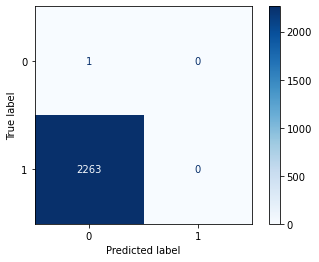

In [160]:
xgb_g_train = xgboost(train, label_train_move, test, label_test_move)
#xgb_g_test = xgboost(train, label_train_move, test, label_test_move,  evaluate = 's')
#xgb_r_train = xgboost(train, label_train_move, test, label_test_move, search = 'r')
#xgb_r_test = xgboost(train, label_train_move, test, label_test_move, evaluate = 's', search = 'r')

In [157]:
#rfc_g_train = randomforest(train,label_train_move, test, label_test_move)
#rfc_g_test = randomforest(train, label_train_move, test, label_test_move,  evaluate = 's')
#rfc_r_train = randomforest(train, label_train, test, label_test,  search = 'r')
#rfc_r_test = randomforest(train, label_train, test, label_test,  evaluate = 's', search = 'r')

C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'random_state': 42, 'max_depth': 4, 'criterion': 'entropy'}
0.9050772626931567
accuracy: 1.0
precision: 1.0
recall: 1.0
f1 1.0
metrics.roc_auc_score 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00      2263

    accuracy                           1.00      2264
   macro avg       1.00      1.00      1.00      2264
weighted avg       1.00      1.00      1.00      2264



C:\Users\sr_te\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'random_state': 42, 'max_depth': 7, 'criterion': 'gini'}
0.9050772626931567
accuracy: 0.5288659793814433
precision: 0.28053365676167374
recall: 0.5288659793814433
f1 0.36660433365079154
metrics.roc_auc_score 0.4990272373540856
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       456
           1       0.53      1.00      0.69       514

    accuracy                           0.53       970
   macro avg       0.26      0.50      0.35       970
weighted avg       0.28      0.53      0.37       970



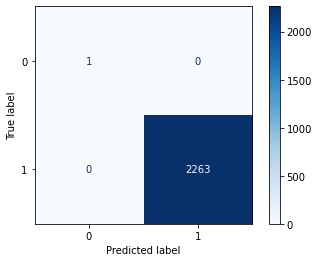

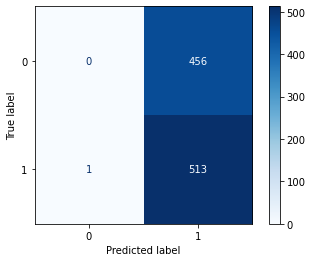

In [158]:
#dt_g_train = decisiontree(train, label_train_move, test, label_test_move)
#dt_g_test = decisiontree(train, label_train_move, test, label_test_move, evaluate = 's')
dt_r_train = decisiontree(train, label_train_move, test, label_test_move, search = 'r')
dt_r_test = decisiontree(train, label_train_move, test, label_test_move, evaluate = 's', search = 'r')